In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
df = pd.read_csv("/Users/gillianmondero/Downloads/Customer_Feedback_Data.csv")
# Check the dataset structure
print(df.head())
print(df.info())

   Customer_ID  Satisfaction_Score  Feedback_Comments  Likelihood_to_Recommend
0            1                10.0     Very satisfied                        9
1            2                 3.0     Very satisfied                        3
2            3                10.0     Very satisfied                        1
3            4                 7.0  Needs improvement                        4
4            5                 8.0     Unsatisfactory                        7
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5050 entries, 0 to 5049
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Customer_ID              5050 non-null   int64  
 1   Satisfaction_Score       4949 non-null   float64
 2   Feedback_Comments        5050 non-null   object 
 3   Likelihood_to_Recommend  5050 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 157.9+ KB
None


In [20]:
# Find and remove duplicate rows
duplicates = df[df.duplicated()]
print(f"Number of duplicate rows: {duplicates.shape[0]}")

df_before = df.shape
df = df.drop_duplicates()
df_after = df.shape

print(f"Shape before removing duplicates: {df_before}")
print(f"Shape after removing duplicates: {df_after}")

Number of duplicate rows: 81
Shape before removing duplicates: (5050, 4)
Shape after removing duplicates: (4969, 4)


In [22]:
# Handle missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)
df['Satisfaction_Score'] = df['Satisfaction_Score'].fillna(df['Satisfaction_Score'].median())

Missing values in each column:
 Customer_ID                  0
Satisfaction_Score         100
Feedback_Comments            0
Likelihood_to_Recommend      0
dtype: int64


In [24]:
# Convert categorical features to numerical
df['Feedback_Comments'] = df['Feedback_Comments'].astype('category')
df['Feedback_Comments_Encoded'] = df['Feedback_Comments'].cat.codes
print("Original and Encoded Feedback_Comments:\n", df[['Feedback_Comments', 'Feedback_Comments_Encoded']].head())

Original and Encoded Feedback_Comments:
    Feedback_Comments  Feedback_Comments_Encoded
0     Very satisfied                          4
1     Very satisfied                          4
2     Very satisfied                          4
3  Needs improvement                          2
4     Unsatisfactory                          3


In [11]:
# Calculate skewness for numeric columns
skewness = df[['Satisfaction_Score', 'Likelihood_to_Recommend']].skew()

# Display skewness
print(skewness)

Satisfaction_Score         5.356323
Likelihood_to_Recommend   -0.017615
dtype: float64


In [26]:
# Calculate IQR for Satisfaction_Score
Q1 = df['Satisfaction_Score'].quantile(0.25)
Q3 = df['Satisfaction_Score'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Impute outliers for Satisfaction_Score with median
df['Satisfaction_Score'] = df['Satisfaction_Score'].apply(lambda x: df['Satisfaction_Score'].median() if x < lower_bound or x > upper_bound else x)

# Calculate IQR for Likelihood_to_Recommend
Q1 = df['Likelihood_to_Recommend'].quantile(0.25)
Q3 = df['Likelihood_to_Recommend'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Impute outliers for Likelihood_to_Recommend with mean
df['Likelihood_to_Recommend'] = df['Likelihood_to_Recommend'].apply(lambda x: df['Likelihood_to_Recommend'].mean() if x < lower_bound or x > upper_bound else x)

# Check Satisfaction_Score for outliers
satisfaction_outliers = df[(df['Satisfaction_Score'] < lower_bound) | (df['Satisfaction_Score'] > upper_bound)]
print(f"Number of outliers in Satisfaction_Score: {satisfaction_outliers.shape[0]}")

# Check Likelihood_to_Recommend for outliers
recommendation_outliers = df[(df['Likelihood_to_Recommend'] < lower_bound) | (df['Likelihood_to_Recommend'] > upper_bound)]
print(f"Number of outliers in Likelihood_to_Recommend: {recommendation_outliers.shape[0]}")

# Clean Satisfaction_Score and Feedback_Comments using updated rules
def clean_feedback(score):
    if score >= 10:
        return "Excellent"
    elif 8 <= score < 10:
        return "Very satisfied"
    elif 5 <= score < 8:
        return "Good service"
    elif 3 <= score < 5:
        return "Needs improvement"
    elif score < 3:
        return "Unsatisfactory"
    return None

# Apply the cleaning function
df['Feedback_Comment'] = df['Satisfaction_Score'].apply(clean_feedback)

# Normalize Satisfaction_Score
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df['Satisfaction_Score_Normalized'] = scaler.fit_transform(df[['Satisfaction_Score']])

# Normalize Likelihood_to_Recommend
df['Likelihood_to_Recommend_Normalized'] = scaler.fit_transform(df[['Likelihood_to_Recommend']])

# Final confirmation
if satisfaction_outliers.empty and recommendation_outliers.empty:
    print("No outliers remain in Satisfaction_Score and Likelihood_to_Recommend.")
else:
    print("Some outliers still exist in the data.")

Number of outliers in Satisfaction_Score: 0
Number of outliers in Likelihood_to_Recommend: 0
No outliers remain in Satisfaction_Score and Likelihood_to_Recommend.


In [14]:
# Remove the original Feedback_Comments column
if 'Feedback_Comments' in df.columns:
    df.drop(columns=['Feedback_Comments'], inplace=True)

print (df)

      Customer_ID  Satisfaction_Score  Likelihood_to_Recommend  \
0               1                10.0                        9   
1               2                 3.0                        3   
2               3                10.0                        1   
3               4                 7.0                        4   
4               5                 8.0                        7   
...           ...                 ...                      ...   
4995          169                 4.0                        3   
4996          520                 7.0                        5   
4997          963                 1.0                        4   
4998          926                 9.0                        1   
4999          598                10.0                       10   

      Feedback_Comments_Encoded   Feedback_Comment  \
0                             4          Excellent   
1                             4  Needs improvement   
2                             4          Exce

In [28]:
# Categorize Likelihood_to_Recommend without overwriting original values
df['Recommendation_Category'] = pd.cut(
    df['Likelihood_to_Recommend'], 
    bins=[0, 4, 7, 10], 
    labels=['Low', 'Medium', 'High'], 
    right=True
)

# Categorize Satisfaction_Score
df['Satisfaction_Category'] = pd.cut(
    df['Satisfaction_Score'], 
    bins=[0, 3, 6, 10], 
    labels=['Dissatisfied', 'Neutral', 'Satisfied'], 
    right=True
)

# Display the updated dataset for the first 5 customers
df.head (5)

,Customer_ID,Satisfaction_Score,Feedback_Comments,Likelihood_to_Recommend,Feedback_Comments_Encoded,Feedback_Comment,Satisfaction_Score_Normalized,Likelihood_to_Recommend_Normalized,Recommendation_Category,Satisfaction_Category
0,1,10.0,Very satisfied,9,4,Excellent,1.000000,0.888889,High,Satisfied
1,2,3.0,Very satisfied,3,4,Needs improvement,0.222222,0.222222,Low,Dissatisfied
2,3,10.0,Very satisfied,1,4,Excellent,1.000000,0.000000,Low,Satisfied
3,4,7.0,Needs improvement,4,2,Good service,0.666667,0.333333,Low,Satisfied
4,5,8.0,Unsatisfactory,7,3,Very satisfied,0.777778,0.666667,Medium,Satisfied


In [30]:
# Summary of the dataset
print("Dataset Summary:\n", df.describe())
print("\nUnique values per column:\n", df.nunique())

Dataset Summary:
        Customer_ID  Satisfaction_Score  Likelihood_to_Recommend  \
count  4969.000000         4969.000000              4969.000000   
mean    501.988126            5.600121                 5.569732   
std     288.781086            2.799185                 2.867726   
min       1.000000            1.000000                 1.000000   
25%     254.000000            3.000000                 3.000000   
50%     502.000000            6.000000                 6.000000   
75%     752.000000            8.000000                 8.000000   
max    1000.000000           10.000000                10.000000   

       Feedback_Comments_Encoded  Satisfaction_Score_Normalized  \
count                4969.000000                    4969.000000   
mean                    2.106058                       0.511125   
std                     1.295283                       0.311021   
min                     0.000000                       0.000000   
25%                     1.000000           

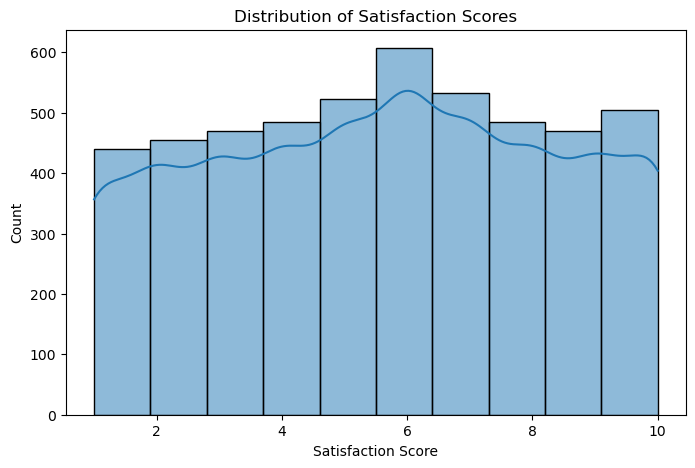

In [32]:
# Distribution plots
plt.figure(figsize=(8, 5))
sns.histplot(df['Satisfaction_Score'], bins=10, kde=True)
plt.title("Distribution of Satisfaction Scores")
plt.xlabel("Satisfaction Score")
plt.ylabel("Count")
plt.show()

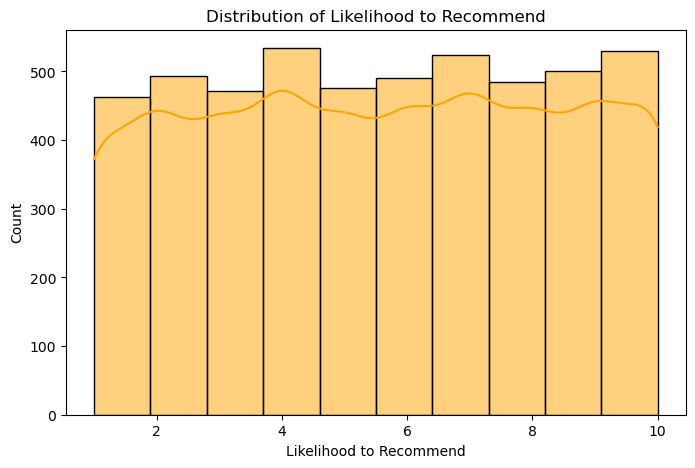

In [34]:
plt.figure(figsize=(8, 5))
sns.histplot(df['Likelihood_to_Recommend'], bins=10, kde=True, color='orange')
plt.title("Distribution of Likelihood to Recommend")
plt.xlabel("Likelihood to Recommend")
plt.ylabel("Count")
plt.show()

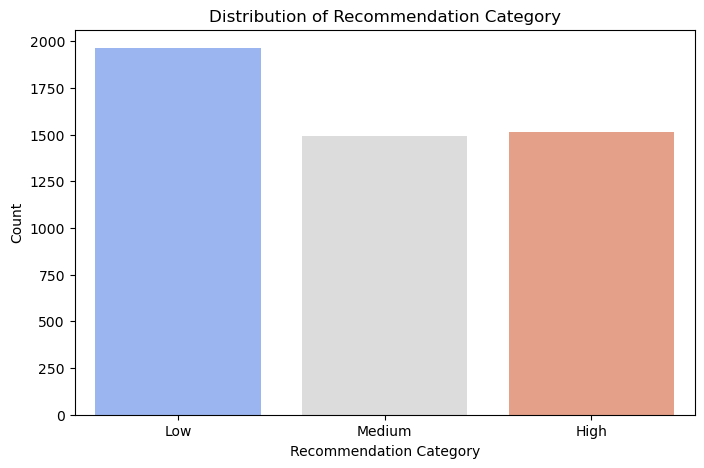

In [38]:
# Count plots
plt.figure(figsize=(8, 5))
sns.countplot(x='Recommendation_Category', data=df, hue='Recommendation_Category', palette='coolwarm', legend=False)
plt.title("Distribution of Recommendation Category")
plt.xlabel("Recommendation Category")
plt.ylabel("Count")
plt.show()

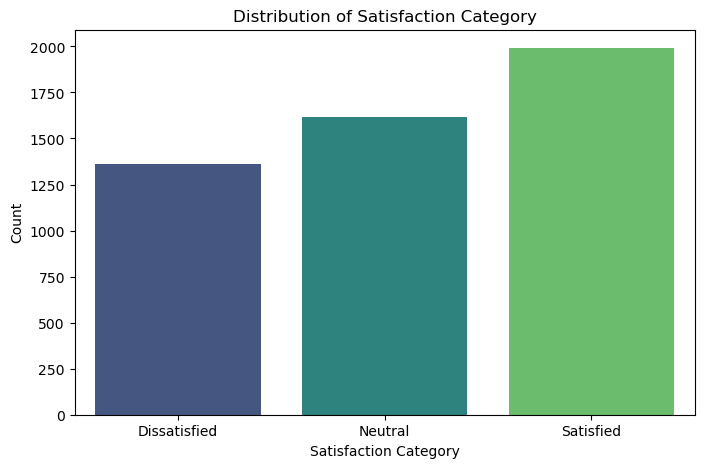

In [50]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Satisfaction_Category', data=df, hue='Satisfaction_Category', palette='viridis', legend=False)
plt.title("Distribution of Satisfaction Category")
plt.xlabel("Satisfaction Category")
plt.ylabel("Count")
plt.show()

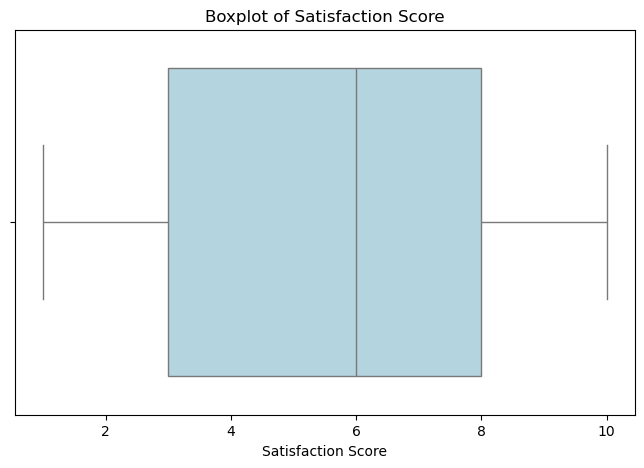

In [42]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df['Satisfaction_Score'], color='lightblue')
plt.title("Boxplot of Satisfaction Score")
plt.xlabel("Satisfaction Score")
plt.show()

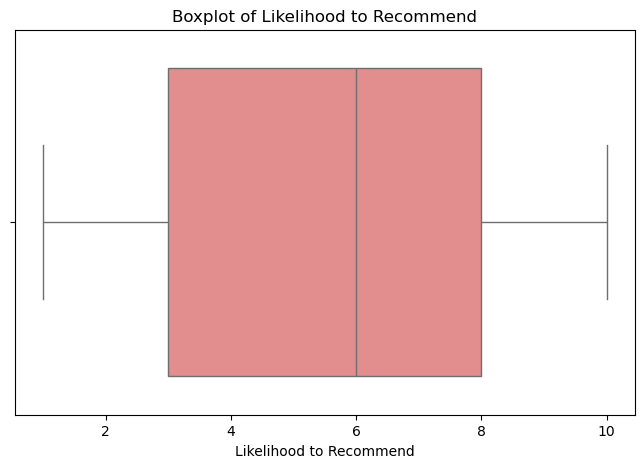

In [44]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df['Likelihood_to_Recommend'], color='lightcoral')
plt.title("Boxplot of Likelihood to Recommend")
plt.xlabel("Likelihood to Recommend")
plt.show()

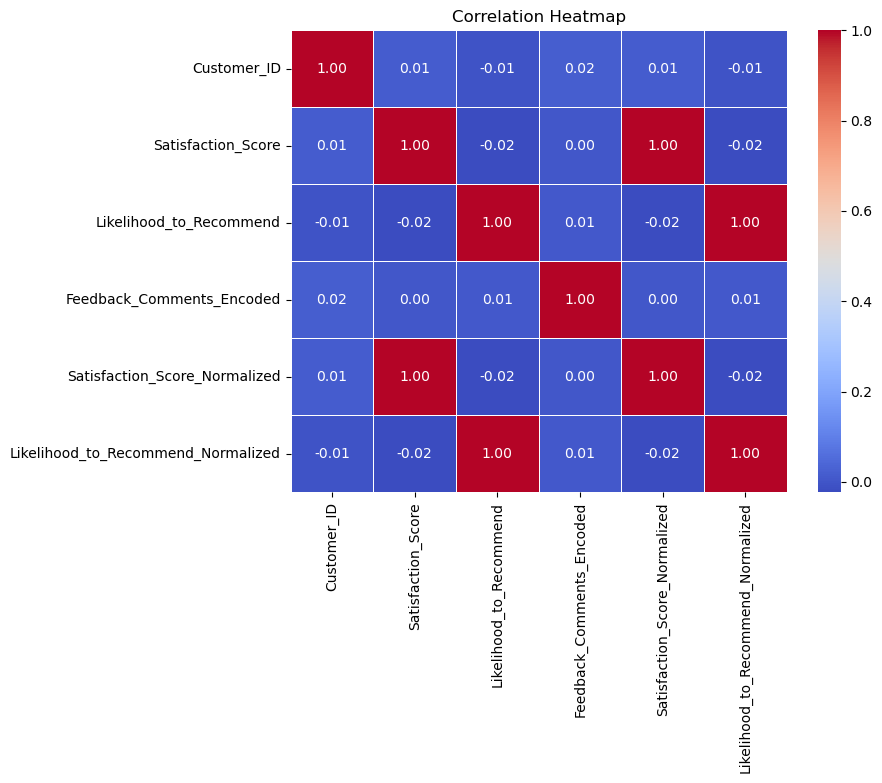

In [46]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [52]:
# Pearson Correlation
pearson_corr, pearson_p = pearsonr(df['Satisfaction_Score'], df['Likelihood_to_Recommend'])
print(f"Pearson Correlation: {pearson_corr:.4f}, p-value: {pearson_p:.4f}")

# Spearman Correlation
spearman_corr, spearman_p = spearmanr(df['Satisfaction_Score'], df['Likelihood_to_Recommend'])
print(f"Spearman Correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4f}")

# Summary statistics per Satisfaction Category
satisfaction_summary = df.groupby("Satisfaction_Category", observed=True)["Satisfaction_Score"].agg(["count", "mean", "std"])
print("\nSatisfaction Category Summary:\n", satisfaction_summary)

# Summary statistics per Recommendation Category
recommendation_summary = df.groupby("Recommendation_Category", observed=True)["Likelihood_to_Recommend"].agg(["count", "mean", "std"])
print("\nRecommendation Category Summary:\n", recommendation_summary)

Pearson Correlation: -0.0230, p-value: 0.1055
Spearman Correlation: -0.0240, p-value: 0.0901

Satisfaction Category Summary:
                        count      mean       std
Satisfaction_Category                           
Dissatisfied            1363  2.021277  0.816669
Neutral                 1615  5.075542  0.819066
Satisfied               1991  8.475640  1.136549

Recommendation Category Summary:
                          count      mean       std
Recommendation_Category                           
Low                       1963  2.548650  1.124308
Medium                    1491  6.032193  0.818599
High                      1515  9.029043  0.817866
